Train CNN with tensorflow

In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import matplotlib.image as img
#import trainCifarStarterCode.py
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Load data: Convert .png images in training and testing datasets into addressable matrices.

# Get the current directory for getting the png data
# import os
# cwd = os.getcwd()

ntrain = 1000 # per class
ntest = 100 # per class
nclass = 10 # number of classes
imsize = 28
nchannels = 1  # No color, only grey scale
batchsize = 1
# Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Train = np.zeros((ntrain*nclass,imsize * imsize))
Test = np.zeros((ntest*nclass,imsize * imsize))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))
itrain = -1
itest = -1

for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = '/notebooks/CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = img.imread(path); # 28 by 28
        im = im.astype(float)
        itrain += 1
        # Train[itrain,:,:,0] = im
        Train[itrain, :] = im.reshape(1, imsize * imsize)
        LTrain[itrain, iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = '/notebooks/CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = img.imread(path); # 28 by 28
        im = im.astype(float)
        itest += 1
        # Test[itest,:,:,0] = im
        Test[itest,:] = im.reshape(1, imsize * imsize)
        LTest[itest,iclass] = 1 # 1-hot lable

# Shuffle the dataset

num_examples = itrain + 1
perm = np.arange(num_examples)
np.random.shuffle(perm)
Train = Train[perm, :]
LTrain = LTrain[perm, :]

In [22]:
np.mean(Train[0:100, 0])

0.55560785355046394

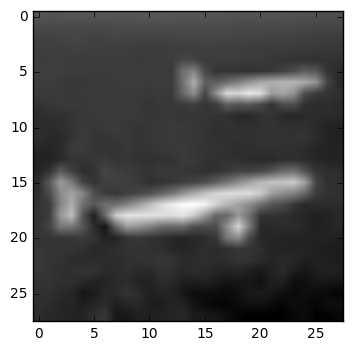

In [23]:
plt.imshow(Train[10,:].reshape(28,28), cmap='gray')

In [11]:
np.mean(Train[100])

0.0023455265267681678

In [11]:
def next_batch(x, y, batch_size, index_in_epoch):
    start = index_in_epoch
    index_in_epoch += batch_size
    num_examples = ntrain * nclass + 1
    if index_in_epoch > num_examples:
        # Shuffle the data
        # perm = np.arange(num_examples)
        # np.random.shuffle(perm)
        # x = x[perm, :]
        # y = y[perm, :]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
    # assert batch_size <= num_examples
    end = index_in_epoch
    return x[start:end, :], y[start:end, :], index_in_epoch


In [15]:
a,b = next_batch(Train, 10, 0)

In [16]:
a.shape

(10, 784)

In [4]:
# Parameters

learning_rate = 0.0000001
training_iters = 200000
batch_size = 20
display_step = 50

# Network parameters for LeNet

n_input = 784
n_classes = 10
dropout = 0.75

# tf Graph input

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)   # dropout


In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides = 1):
    # Conv2D wrapper, with bias and relu actiation
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k = 2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

# Create model
def conv_net(x, weights, biases, dropout):
    # reshape input picture
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    # Convolution layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k = 2) # Pooling size k = 2
    
    # Convolutaion layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling
    conv2 = maxpool2d(conv2, k = 2) 
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    # Apply dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out    

In [6]:
# Store layers weight & bias
weights = {
    # 5*5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5*5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7 * 7 * 64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 input, 10 outputs (one hot)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}
                       
biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
        }
                       
# Construct model
pred = conv_net(x, weights, biases, keep_prob)
                       
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred,y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# Initialzing the variables
init = tf.initialize_all_variables()

In [7]:
#  Launch the gragh
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    batch_start = 0
    index_in_epoch_X = 0
    index_in_epoch_y = 0
    while batch_start + batch_size < training_iters:
        batch_x, index_in_epoch_X = next_batch(Train, batch_size, index_in_epoch_X)
        batch_y, index_in_epoch_y = next_batch(LTrain, batch_size, index_in_epoch_y)
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob:dropout})
        
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.})
            
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
        step += 1
        
    print ("Optimization Finished!")
        
    # Calculate accuracy for 256 CIFAR10 test images
    print ("Testing Accuracy:", sess.run(accuracy, feed_dict = {x: Test[:256], y: LTest[:256], keep_prob: 1.}))
        

Iter 1000, Minibatch Loss= 60216.960938, Training Accuracy= 0.00000
Iter 2000, Minibatch Loss= 2.017383, Training Accuracy= 0.95000
Iter 3000, Minibatch Loss= 29138.175781, Training Accuracy= 0.00000


KeyboardInterrupt: 